In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset

block_size = 3  # context length: how many characters do we take to predict the next one
X, Y = [], []
for w in words:#[:5]:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [33]:
# split the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Playing around

In [12]:
C = torch.randn((27, 2))

In [21]:
C[:].shape

torch.Size([27, 2])

In [24]:
C[X].shape

torch.Size([32, 3, 2])

In [29]:
print(
    X[13, 2],  # 13th 3-character entry in the dataset, 3rd character's index
    C[X][13, 2],  # 13th 3-character entry in the dataset, 3rd character's embedding
    C[1],  # equivalent to the above
)

tensor(1) tensor([-0.4742,  0.7734]) tensor([-0.4742,  0.7734])


In [30]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [31]:
# Hidden layer
W1 = torch.randn((6, 100))
b1 = torch.randn((100,))
# we roughly want emb @ W1 + b1; but we need to concatenate the embeddings first

In [55]:
# sub-optimal way of doing it
print("Using cat manually:")
print(torch.cat((emb[:, 0], emb[:, 1], emb[:, 2]), dim=1).shape)
print("Using unbind to generalize over any block_size:")
print(len(torch.unbind(emb, dim=1)), torch.unbind(emb, dim=1)[0].shape)
print(torch.cat(torch.unbind(emb, dim=1), dim=1).shape)

Using cat manually:
torch.Size([32, 6])
Using unbind to generalize over any block_size:
3 torch.Size([32, 2])
torch.Size([32, 6])


In [57]:
# Optimal way: use tensor.view()
emb.view(32, -1).shape

torch.Size([32, 6])

In [58]:
# broadcasting b1 will take care of the shapes
#  32, 100  (emb @ W1)
#  100  ==> 1, 100  (result + b1)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [59]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27,))

In [60]:
logits = h @ W2 + b2

In [61]:
logits.shape

torch.Size([32, 27])

In [68]:
counts = logits.exp()

In [70]:
prob = counts / counts.sum(1, keepdims=True)

In [71]:
prob.shape

torch.Size([32, 27])

In [73]:
torch.sum(prob, 1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [74]:
prob[torch.arange(32), Y]  # prob of the correct class for each example

tensor([2.8615e-14, 1.2541e-16, 1.8549e-09, 1.7975e-06, 2.1749e-13, 7.1968e-07,
        4.8476e-10, 2.1019e-08, 6.8788e-03, 9.3185e-08, 5.5820e-04, 3.8671e-07,
        9.2466e-10, 2.7256e-11, 5.9056e-10, 3.3182e-08, 3.8350e-09, 6.8265e-10,
        4.5690e-07, 1.2086e-01, 1.4537e-10, 3.9612e-06, 4.9416e-13, 1.4472e-07,
        1.9870e-13, 1.1947e-10, 9.6366e-04, 1.5509e-07, 1.0370e-11, 1.5662e-04,
        5.4430e-09, 1.0212e-12])

In [78]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(18.8239)

### Everything tidied up

In [99]:
Xtr.shape, Ytr.shape  # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [100]:
track = True

In [101]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [102]:
sum(p.nelement() for p in parameters)

11897

```python
emb = C[X]  # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # 32, 100
logits = h @ W2 + b2  # 32, 27
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)  # equivalent to the 3 lines above
# Using cross_entropy is more numerically stable (due to exp), and forward and backward are more efficient
loss
```

In [103]:
for p in parameters:
    p.requires_grad = True

In [104]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# lrs

In [105]:
lri = []
lossi = []
stepi = []

In [111]:
for i in range(200000):
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]]  # 32, 3, 2
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # 32, 100
    logits = h @ W2 + b2  # 32, 27
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    if track:
        lr = 0.1 if i < 100000 else 0.01  # or 0.01 for lr decay
        # lr = lrs[i]
    else:
        lr = 0.1  # or 0.01 for lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if track:
        # lri.append(lre[i])
        stepi.append(i)
        lossi.append(loss.log10().item())

# print(loss.item())

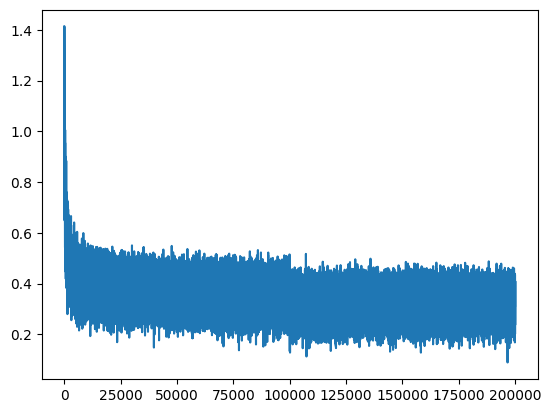

In [112]:
plt.plot(stepi, lossi)

In [108]:
# if track:
#     plt.plot(lri, lossi)

In [113]:
# loss on all the data
emb = C[Xdev]  # all entries, 3, 2
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # 32, 100
logits = h @ W2 + b2  # 32, 27
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1589, grad_fn=<NllLossBackward0>)

In [114]:
# loss on all the data
emb = C[Xte]  # all entries, 3, 2
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # 32, 100
logits = h @ W2 + b2  # 32, 27
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1578, grad_fn=<NllLossBackward0>)

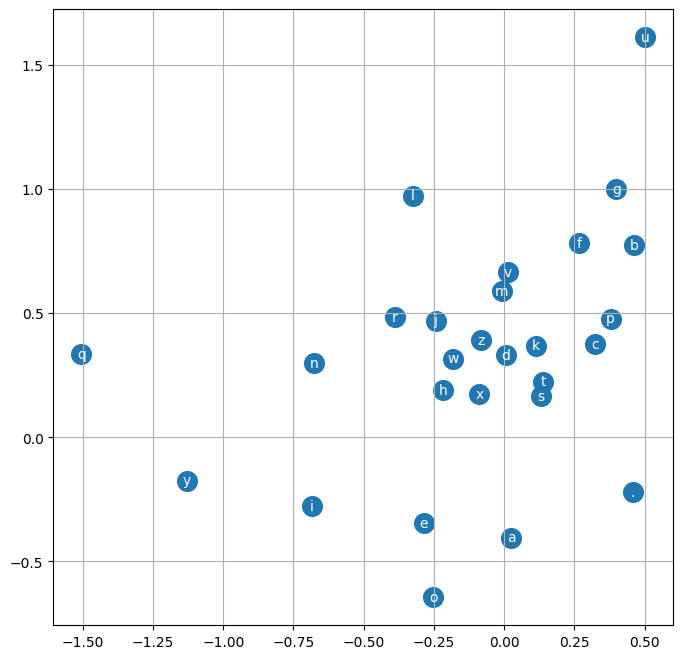

In [80]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")

plt.grid("minor")

In [ ]:
# train, dev/val, test splits
# 80%, 10%, 10%

### Sampling from the model

In [115]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

mohavimyah.
see.
madyn.
alee.
thruthadrie.
cadeer.
meliianni.
jenleigh.
van.
aar.
elle.
malaia.
noshibergiaganest.
jairenelipxetton.
kuma.
geder.
yarue.
eli.
kayshayveyah.
hil.
